In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib widget

In [3]:
#load data/Load_MIDC_10yrs.csv as a dataframe
dfX = pd.read_csv("data/Temp_NWPP_10yrs.csv")
dfY = pd.read_csv("data/RTLoad_MIDC+NW_10yrs.csv")
#subtract 7 hours from datetime to convert from UTC to PST
dfY['datetime'] = pd.to_datetime(dfY['datetime'])
dfY['datetime'] = dfY['datetime'] - pd.Timedelta(hours=7)
dfX['datetime'] = pd.to_datetime(dfX['datetime'])
dfX['datetime'] = (dfX['datetime'] - pd.Timedelta(hours=7))

In [5]:
#groupby name and date, then find sum and max of load
selected_names = {
    'PGE': 'Portland General Electric Company',
    'AVA': 'Avista Corporation',
    'GCPD': 'PUD No. 2 of Grant County, Washington',
    'PSEI': 'Puget Sound Energy, Inc.',
    'TPWR': 'City of Tacoma, Department of Public Utilities',
    'BPA': 'BPA',
    'DOPD': 'PUD No. 1 of Douglas County',
    'SCL': 'Seattle City Light',
    'CHPD': 'Public Utility District No. 1 of Chelan County',
    'PACW': 'PACW-TAC',   # this line is different from EICLoadanalysis.ipynb
    'Total': 'Total'
}

In [10]:
Load=dfY[(dfY['name'].isin(list(selected_names.values())[:-1]))&(dfY['datetime'].dt.date > pd.to_datetime('2022-03-01').date())&(dfY['datetime'].dt.date < pd.to_datetime('2025-06-01').date())].groupby('datetime').agg({'avgvalue': 'sum'}).rename(columns={'avgvalue': 'Total Load'})
Temp=dfX[(dfX['station_name']=='NWPP')&(dfX['datetime'].dt.date > pd.to_datetime('2022-03-01').date())&(dfX['datetime'].dt.date < pd.to_datetime('2025-06-01').date())][['datetime','temperature']].set_index('datetime')

In [19]:
#remove all rows with temperature less than 0 or greater than 120
Tload = Tload[(Tload['temperature'] >= 0) & (Tload['temperature'] <= 120)]

<Axes: title={'center': 'Total Load from 2022-03-01 to 2025-06-01'}, xlabel='datetime'>

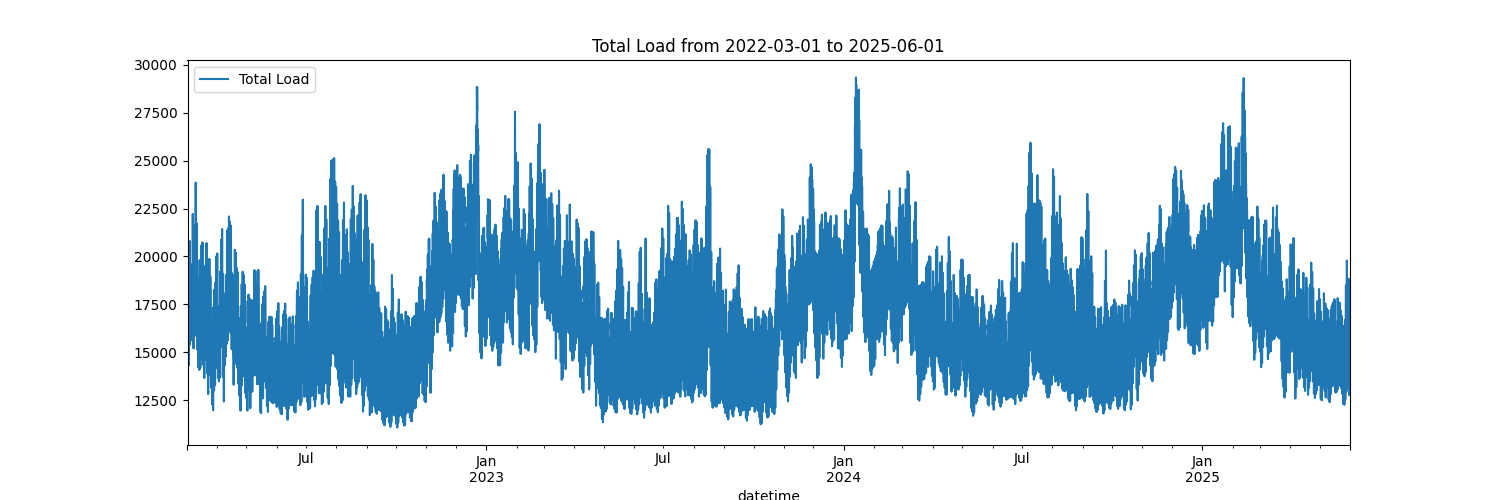

In [9]:
#plot Tload
Tload.plot(x='datetime', y='Total Load', figsize=(15, 5), title='Total Load from 2022-03-01 to 2025-06-01')

Text(0, 0.5, 'Total Load (MW)')

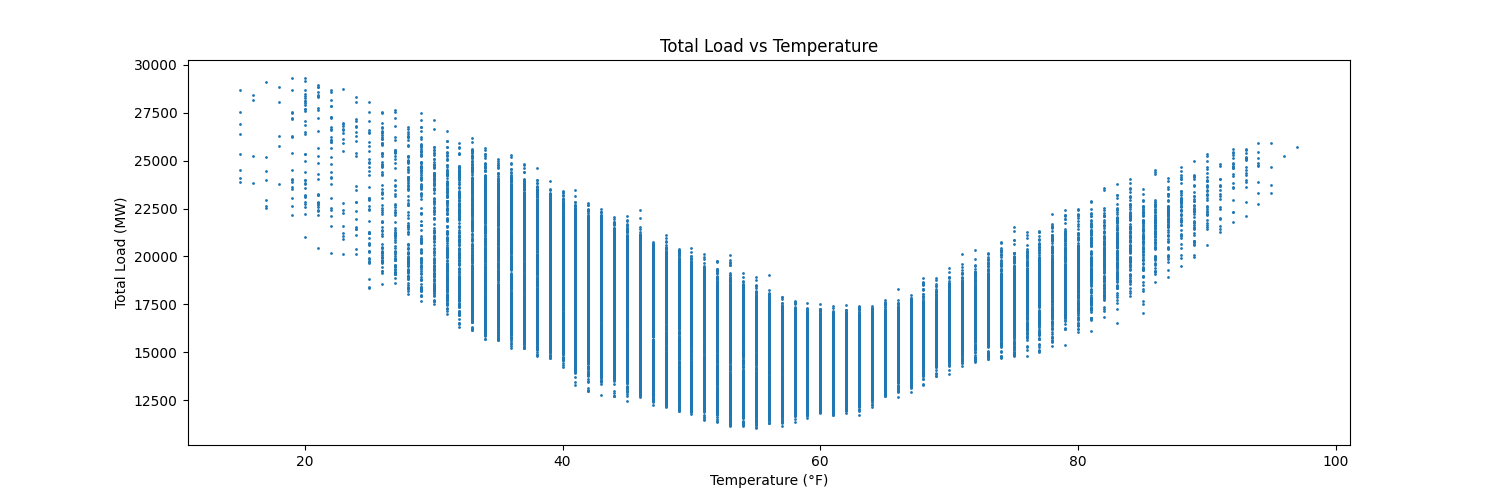

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Join the Load and Temp dataframes
Tload = Load.join(Temp)

# Remove outliers before fitting the model
Tload = Tload[(Tload['temperature'] >= 0) & (Tload['temperature'] <= 120)]
Tload = Tload.dropna()

# Prepare data for polynomial regression
X = Tload[['temperature']]
y = Tload['Total Load']

# Create and fit the polynomial regression model (degree=3)
degree = 2
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X, y)

# Add the regression predictions to the Tload dataframe
Tload['Predicted Load'] = model.predict(X)

# Reset index to make 'datetime' a column for plotting
Tload = Tload.reset_index()

print(f"Polynomial Regression Model (degree={degree}) fitted.")
# Note: Coefficients for polynomial regression are more complex.
# You can inspect them via model.named_steps['linearregression'].coef_

Polynomial Regression Model (degree=2) fitted.


R2 Score: 0.47275273375248217


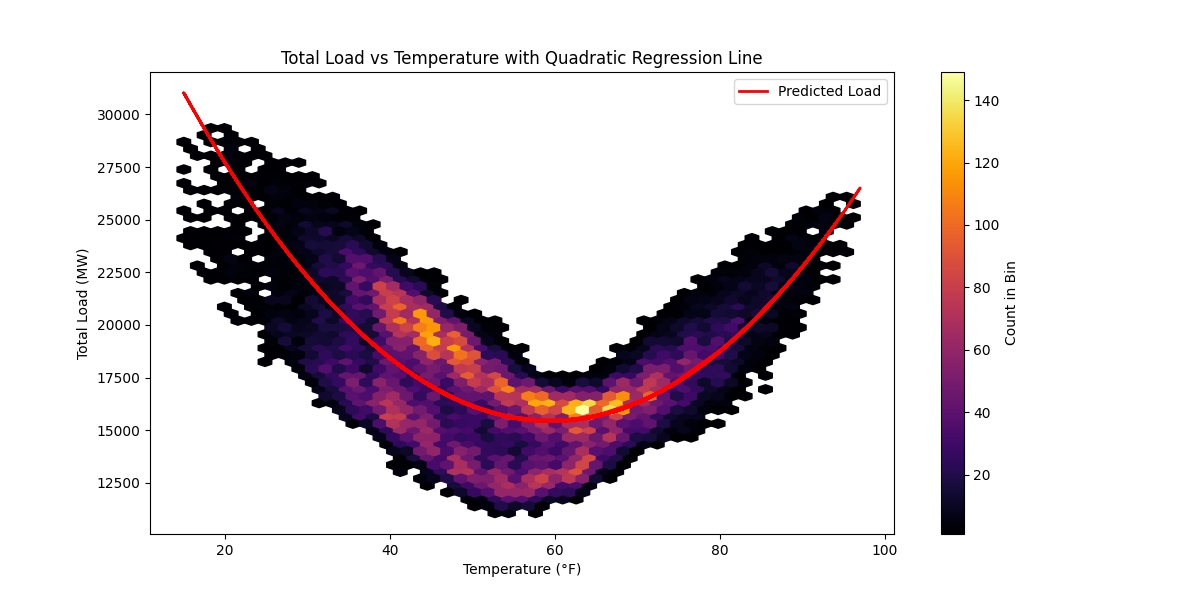

In [30]:
plt.figure(figsize=(12, 6))
plt.hexbin(Tload['temperature'], Tload['Total Load'], gridsize=50, cmap='inferno', mincnt=1)
plt.colorbar(label='Count in Bin')
plt.plot(Tload['temperature'], Tload['Predicted Load'], color='red', label='Predicted Load', linewidth=2)
plt.title('Total Load vs Temperature with Quadratic Regression Line')
plt.xlabel('Temperature (°F)')
plt.ylabel('Total Load (MW)')
plt.legend()
#print R2 score
from sklearn.metrics import r2_score
r2 = r2_score(Tload['Total Load'], Tload['Predicted Load'])
print(f"R2 Score: {r2}")